In [1]:
import pickle
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.neighbors import KNeighborsRegressor

from simantha import Source, Machine, Buffer, Sink, Maintainer, System, simulation, utils

matplotlib.rcParams.update({'font.size': 14})

random.seed(1)

In [2]:
class SensingEvent(simulation.Event):
    def get_action_priority(self):
        return 5.5

class ConditionMonitoredMachine(Machine):
    def __init__(self, sensing_interval=1, sensor_noise=0, **kwargs):
        self.sensing_interval = sensing_interval
        self.sensor_noise = sensor_noise
        self.sensor_data = {'time': [], 'reading': []}
        
        super().__init__(**kwargs)
    
    def initialize_addon_processes(self):
        self.env.schedule_event(
            self.env.now, 
            self, 
            self.sense, 
            f'{self.name} initial addon process',
            event_type=SensingEvent
        )
        
    def repair_addon_processes(self):
        self.env.schedule_event(
            self.env.now,
            self,
            self.sense,
            f'{self.name} repair addon process at {self.env.now}',
            event_type=SensingEvent
        )
    
    def sense(self):
        self.sensor_reading = self.health + np.random.normal(0, self.sensor_noise)
        
        self.sensor_data['time'].append(self.env.now)
        self.sensor_data['reading'].append(self.sensor_reading)
        
        self.env.schedule_event(
            self.env.now+self.sensing_interval,
            self,
            self.sense,
            f'{self.name} sensing at {self.env.now}',
            event_type=SensingEvent
        )

In [3]:
degradation_matrix = utils.generate_degradation_matrix(h_max=10, p=0.1)
cm_distribution = {'geometric': 0.1}

source = Source()
M1 = ConditionMonitoredMachine(
    name='M1',
    cycle_time=2,
    degradation_matrix=degradation_matrix,
    cm_distribution=cm_distribution,
    sensing_interval=2,
    sensor_noise=2
)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(upstream=[M1])

system = System(objects=[source, M1, sink])

random.seed(1)
system.simulate(simulation_time=360)

Simulation finished in 0.03s
Parts produced: 167


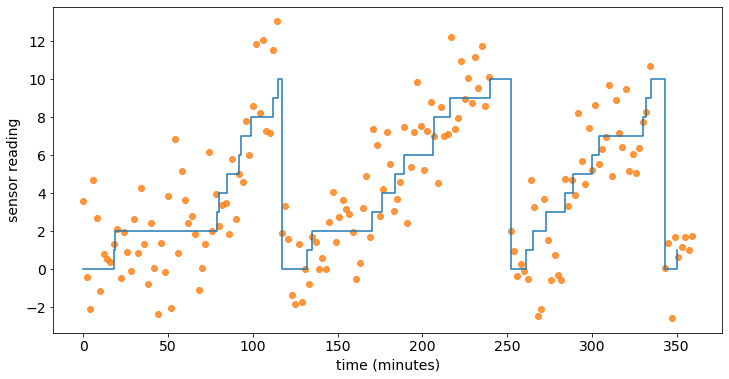

In [4]:
plt.figure(figsize=(12,6))

plt.step(M1.health_data['time'], M1.health_data['health'], where='post')
plt.scatter(M1.sensor_data['time'], M1.sensor_data['reading'], c='C1', alpha=0.8)

plt.xlabel('time (minutes)')
plt.ylabel('sensor reading')

plt.show()

In [6]:
X = np.array([M1.sensor_data['time']]).T
y = np.array([M1.sensor_data['reading']]).T

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X, y)

KNeighborsRegressor()

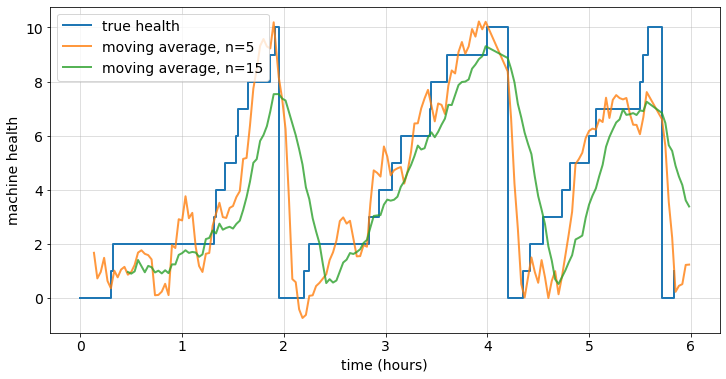

In [9]:
plt.figure(figsize=(12,6))

plt.step(
    M1.health_data['time'], 
    M1.health_data['health'], 
    where='post', lw=2, label='true health'
)

#plt.plot(X, knn.predict(X), label='predicted health')

for window in [5, 15]:
    plt.plot(
        X[window-1:], 
        np.convolve(y[:,0], np.ones((window,))/window, mode='valid'), 
        lw=2, alpha=0.8, label=f'moving average, n={window}'
    )

plt.xticks(np.arange(0, 361, 60), np.arange(7))
plt.xlabel('time (hours)')
plt.ylabel('machine health')

plt.grid(alpha=0.5)
plt.legend()
plt.show()